In [1]:
#PART 1: Importing modules
from swiglpk import *
import matplotlib.pyplot as plt
import numpy as np
from scikits.odes import dae

In [2]:
#PART 2: Initial conditions
t=0
tmax=2
y=1
steps=40000
v=1
ub = [100.0,600.0,300.0,0,0,0]
epsilon = 1e-5
troot = 0
T = []
x1out = np.array([])
x2out = np.array([])
x3out = np.array([])
Zout = np.array([])
yout = np.array([])
feasible = True
bl = [0,0,0,0,0,0]
ind = intArray(1+3)
val = doubleArray(1+3)
x = [0,0,0,0,0,0]
cinit = [0,0,0,10.0,6.0,4.0]
c = cinit.copy()
Zp = []
x1p = []
x2p = []
x3p = []

#PART 3: setting up and solving our initial unchanged problem for the optimal basis the first time
ia = intArray(1+1000); ja = intArray(1+1000);
ar = doubleArray(1+1000);
lp = glp_create_prob();
glp_set_prob_name(lp, "sample");
glp_set_obj_dir(lp, GLP_MAX); #Set the objective direction
glp_add_rows(lp, 3);
glp_set_row_name(lp, 1, "p");
glp_set_row_bnds(lp, 1, GLP_UP, 0.0, ub[0]);
glp_set_row_name(lp, 2, "q");
glp_set_row_bnds(lp, 2, GLP_UP, 0.0, ub[1]);
glp_set_row_name(lp, 3, "r");
glp_set_row_bnds(lp, 3, GLP_UP, 0.0, ub[2]);
glp_add_cols(lp, 3);
glp_set_col_name(lp, 1, "x1");
glp_set_col_bnds(lp, 1, GLP_LO, 0.0, 0.0);
glp_set_obj_coef(lp, 1, c[3]);
glp_set_col_name(lp, 2, "x2");
glp_set_col_bnds(lp, 2, GLP_LO, 0.0, 0.0);
glp_set_obj_coef(lp, 2, c[4]);
glp_set_col_name(lp, 3, "x3");
glp_set_col_bnds(lp, 3, GLP_LO, 0.0, 0.0);
glp_set_obj_coef(lp, 3, c[5]);
ia[1] = 1; ja[1] = 1; ar[1] = 1.0; # a[1,1] = 1
ia[2] = 1; ja[2] = 2; ar[2] = 1.0; # a[1,2] = 1
ia[3] = 1; ja[3] = 3; ar[3] = 1.0; # a[1,3] = 1
ia[4] = 2; ja[4] = 1; ar[4] = 10.0; # a[2,1] = 10
ia[5] = 3; ja[5] = 1; ar[5] = 2.0; # a[3,1] = 2
ia[6] = 2; ja[6] = 2; ar[6] = 4.0; # a[2,2] = 4
ia[7] = 3; ja[7] = 2; ar[7] = 2.0; # a[3,2] = 2
ia[8] = 2; ja[8] = 3; ar[8] = 5.0; # a[2,3] = 5
ia[9] = 3; ja[9] = 3; ar[9] = 6.0; # a[3,3] = 6
glp_load_matrix(lp, 9, ia, ja, ar);
glp_simplex(lp, None);
Z = glp_get_obj_val(lp);
Zmax = Z
x1 = glp_get_col_prim(lp, 1);
x[3] = x1
x2 = glp_get_col_prim(lp, 2);
x[4] = x2
x3 = glp_get_col_prim(lp, 3);
x[5] = x3
x4 = glp_get_row_prim(lp, 1);
x[0] = x4
x5 = glp_get_row_prim(lp, 2);
x[1] = x5
x6 = glp_get_row_prim(lp, 3);
x[2] = x6
print("\nZ = %g; x1 = %g; x2 = %g; x3 = %g\n" % (Z, x1, x2, x3))

#LOOP:
while t < tmax:
    #PART 4: finding out which variables are basic/non-basic upper/lower
    basis = []
    upper = []
    lower = []
    for j in range(0,3):
        bl[j] = glp_get_row_stat(lp,j+1)
            
    for j in range(0,3):
        bl[j+3] = glp_get_col_stat(lp,j+1)

    for j in range(0,6):
        if bl[j] == 0:
            print("error")
        
        elif bl[j] == 1:
            basis = basis + [j+1]

        elif bl[j] == 2:
            lower = lower + [j+1]

        elif bl[j] == 3:
            upper = upper + [j+1]

    nonbasic = upper + lower
    nonbasic.sort()
    #PART 5a: extracting data from simplex tableau so we can calculate xB = E * xN later
    ind = intArray(1+3) #initialise indexes
    val = doubleArray(1+3) #initialise values
    lengths = [0,0,0] #initialise lengths
    indlist = [] #initialise index list
    vallist = [] #initialise value list
    d = [0,0,0,0,0,0]
    for j in range(0,len(basis)): #for each basic variable
        indcopy = []
        valcopy = []
        leng = glp_eval_tab_row(lp,basis[j],ind,val) #receives the values of the coefficients and their indices
        lengths[j] = leng #stores the number of coefficients
        for k in range(0,leng):
            indc = ind[k+1]
            valc = val[k+1]
            indcopy = indcopy + [indc]
            valcopy = valcopy + [valc]
        indlist.append(indcopy) #stores the indices
        vallist.append(valcopy) #stores the values

    #PART 5b: transposing the tableau for use later
    indT = []
    indTlist = []
    lengthsT = []
    for j in range(0,len(indlist)):
        for k in range(0,len(nonbasic)):
            if nonbasic[j] in indlist[k]:
                indT = indT + [nonbasic[k]]
        indTlist.append(indT)
        lengthsT = lengthsT + [len(indT)]
        indT = []
        
    #PART 6: solving the DAE continuously
    initX = x + [Z,y] #x1,x2,x3,x4,x5,x6,z,v,y
    initXp = [0,0,0,0,0,0,0,-v*y]
    tin = np.linspace(troot, tmax, steps+1-len(T))
    
    def reseqn(tin, X, Xdot, result):
        # we create residual equations for the problem
        #nonbasic lower variables
        for j in lower:
            result[j-1] = X[j-1]
            
        #nonbasic upper variables
        for j in upper:
            result[j-1] = ub[j-1] - X[j-1]
    
        #basic variables
        for j in range(0,len(basis)):
            result[basis[j]-1] = -X[basis[j]-1]
            for k in range(0,lengths[j]):
                result[basis[j]-1] += X[indlist[j][k]-1]*vallist[j][k]
    
        #objective function
        result[6] = 10*X[3] + 6*X[4] + 4*X[5] - X[6]
        
        #differential components
        if 2 in upper:
            result[1] = ub[1]*X[7] - X[1]
        
        result[7] = X[7]*X[6] / Zmax + Xdot[7]
    
    def rootfind(tin,X,Xdot,result):
        #our rootfinding function
        for j in range(0,len(basis)):
            result[j] = X[basis[j]-1] + epsilon
    
    solver = dae('ida', reseqn, atol=1e-12, rtol=1e-10, rootfn=rootfind, nr_rootfns = 3)
    result = solver.solve(tin, initX, initXp)
    
    #PART 7: store relevant values
    try:
        troot = result.roots.t.item()
        x1outroot = result.roots.y[0,3]
        x2outroot = result.roots.y[0,4]
        x3outroot = result.roots.y[0,5]
        Zoutroot = result.roots.y[0,6]
        y = result.roots.y[-1,7]
        youtroot = y
        v = result.roots.y[-1,6]/Zmax
    except:
        t = tmax + 1 
        troot = []
        x1outroot = []
        x2outroot = []
        x3outroot = []
        Zoutroot = []
        youtroot = []
        
    
    T = np.append(np.append(T,result.values.t),troot)
    x1out = np.append(np.append(x1out,result.values.y[:, 3]),x1outroot)
    x2out = np.append(np.append(x2out,result.values.y[:, 4]),x2outroot)
    x3out = np.append(np.append(x3out,result.values.y[:, 5]),x3outroot)
    Zout = np.append(np.append(Zout,result.values.y[:,6]),Zoutroot)
    yout = np.append(np.append(yout,result.values.y[:,7]),youtroot)
    
    #PART 8: rerunning our simplex method to find a new optimal basis
    glp_set_row_bnds(lp, 2, GLP_UP, 0.0, ub[1]*y)
    glp_load_matrix(lp,9,ia,ja,ar)
    glp_simplex(lp,None)
    Z = glp_get_obj_val(lp)
    x[3] = glp_get_col_prim(lp,1) #these are to get our plotting to work correctly
    x[4] = glp_get_col_prim(lp,2)
    x[5] = glp_get_col_prim(lp,3)
    x[0] = glp_get_row_prim(lp,1)
    x[1] = glp_get_row_prim(lp,2)
    x[2] = glp_get_row_prim(lp,3)
    feasible = True #we reset feasible to be true again
    print(T[-1])


Z = 733.333; x1 = 33.3333; x2 = 66.6667; x3 = 0
GLPK Simplex Optimizer 5.0
3 rows, 3 columns, 9 non-zeros
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (3)
*     2: obj =   7.333333333e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND

0.4505478916665567
GLPK Simplex Optimizer 5.0
3 rows, 3 columns, 9 non-zeros
      2: obj =   5.999999600e+02 inf =   1.000e-05 (1)
      3: obj =   5.999999100e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
2.0GLPK Simplex Optimizer 5.0
3 rows, 3 columns, 9 non-zeros

*     3: obj =   5.999999100e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND


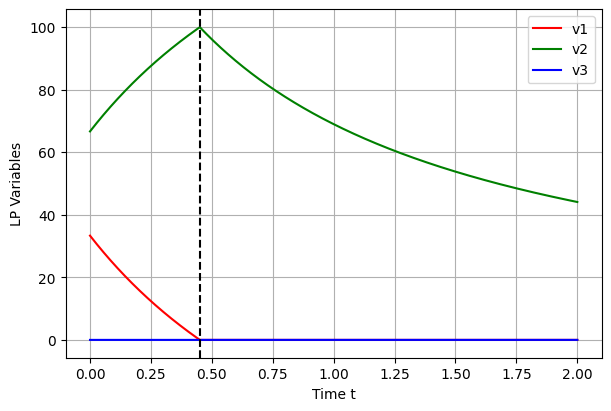

In [3]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
plt.plot(T, x1out, 'r', label='v1')
plt.plot(T, x2out, 'g', label='v2')
plt.plot(T, x3out, 'b', label='v3')
plt.plot([0.4505478916665567,0.4505478916665567], [-5.7,105.7], 'k--')
plt.axis((-0.1,2.1,-5.7,105.7))
plt.legend(loc='best')
plt.ylabel('LP Variables')
plt.xlabel('Time t')
plt.grid()
plt.show()

Text(0, 0.5, 'Objective z')

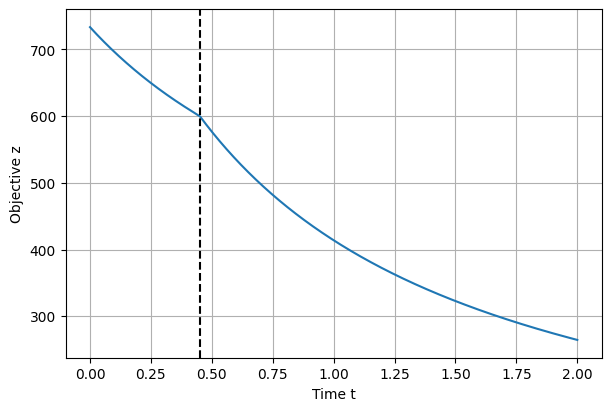

In [4]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
linesz = ax.plot(T,Zout,label="z")
plt.plot([0.4505478916665567,0.4505478916665567], [237.9,2200/3+26.7], 'k--')
plt.axis((-0.1,2.1,237.9,2200/3+26.7))
plt.grid()
ax.set_xlabel("Time t")
ax.set_ylabel("Objective z")

Text(0, 0.5, 'Kinetic Variable x')

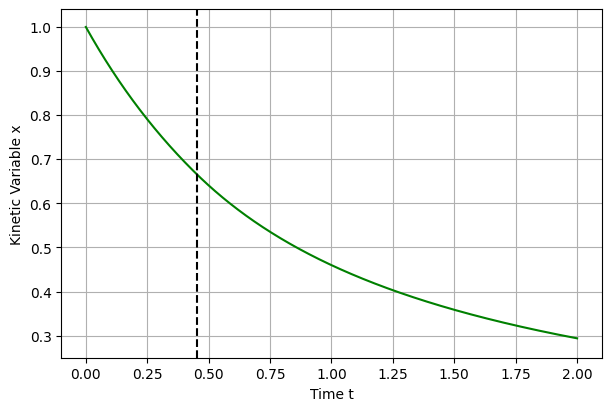

In [5]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')
linesz = ax.plot(T,yout, 'g',label="y")
plt.plot([0.4505478916665567,0.4505478916665567], [0.25,1.04], 'k--')
plt.axis((-0.1,2.1,0.25,1.04))
plt.grid()
ax.set_xlabel("Time t")
ax.set_ylabel("Kinetic Variable x")